# Clustering: Gamma Ray Bursts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture as gauss

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

# File fetch and read

## Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)


In [2]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt", 'r') as f:
    names= np.array([n.strip().replace(" ", "_") for n in f.readlines()[1].replace("#", "").replace("\n", "").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
data.T

array([['GRB230514A*', 'GRB230514996', '23:54:16.152', ..., '5.8880',
        'True', '60078.99602028'],
       ['GRB230513A*', 'GRB230513929', '22:17:18.149', ..., '4.8000',
        'True', '60077.92868228'],
       ['GRB230512A*', 'GRB230512269', '6:27:45.413', ..., '2.6240',
        'True', '60076.26927561'],
       ...,
       ['GRB910424A*', 'None', '19:43:25.064', ..., '3.1360', 'False',
        '48370.82181787'],
       ['GRB910423A*', 'None', '19:51:15.804', ..., '208.5760', 'False',
        '48369.82726625'],
       ['GRB910421A*', 'None', '9:14:03.800', ..., '5.6960', 'False',
        '48367.38476620']], dtype='<U14')

## Clustering t90

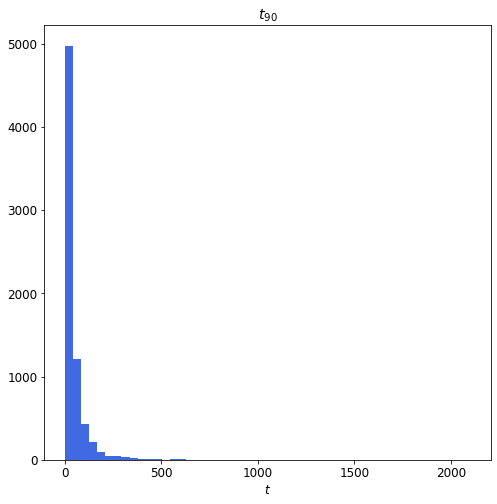

In [5]:
t90 = np.array(data[6, :], dtype=float)
filter = t90 >= 0 
t90_clean = t90[filter]


plt.hist(t90_clean, bins=50, color='royalblue')
plt.title(r'$t_{90}$')
plt.xlabel(r'$t$')
plt.show()

## Let's see how does the log compare

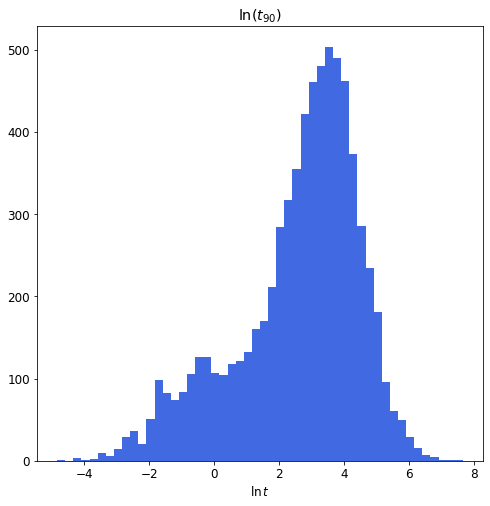

In [6]:
plt.hist(np.log(t90_clean), bins=50, color='royalblue')
plt.title(r'$\ln(t_{90})$')
plt.xlabel(r'$\lnt$')
plt.show()

In [7]:
#KDE

def kde_sklearn(data, grid, bandwidth = 1.0, kernel="linear"):
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(data[:, None])
    log_pdf = kde.score_samples(grid[:, np.newaxis])
    
    #Result of fit is a log pdf
    pdf = np.exp(log_pdf)
    return pdf

t90_log = np.log(t90_clean)

tgrid = np.linspace(t90_log.min(), t90_log.max(), 1000)

t90_kde = kde_sklearn(data=t90_log, grid=tgrid)

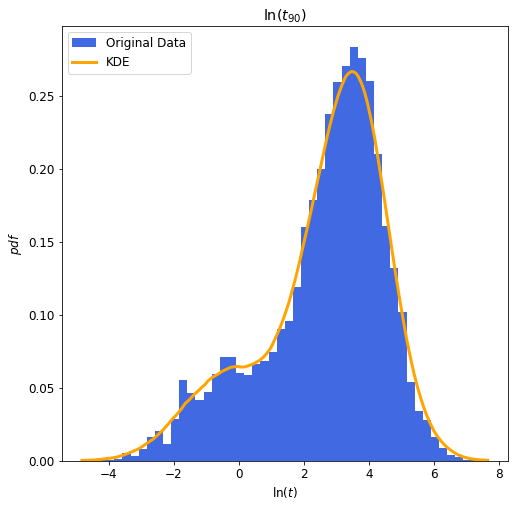

In [8]:
#Plotting

plt.hist(t90_log, bins=50, density=True, color='royalblue', label='Original Data', zorder=1)
plt.plot(tgrid, t90_kde, c='orange', label='KDE', lw=3, zorder=2)

plt.title(r'$\ln(t_{90})$')
plt.xlabel(r'$\ln(t)$')
plt.ylabel(r'$pdf$')
plt.legend(loc='upper left')
plt.show()

In [9]:
#K-Means clustering -> Unsupervised, but we're fairly confident that there are 2 clusters in there
cluster = KMeans(n_clusters=2)
cluster.fit(t90_log[:, None])

KMeans(n_clusters=2)

In [10]:
#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(t90_log[:, None])

print(centers.shape)
print(labels.shape)

(2, 1)
(7113,)


In [11]:
#Reordering clusters such that the first one is always the smaller value, also reordering labels

if centers[0] > centers[1]:
    #Reversing the order of the clusters
    centers = centers[::-1]
    #Changing the values of the labels accordingly 0 <--> 1
    labels = np.array(~np.array(labels, dtype='bool'), dtype='int')

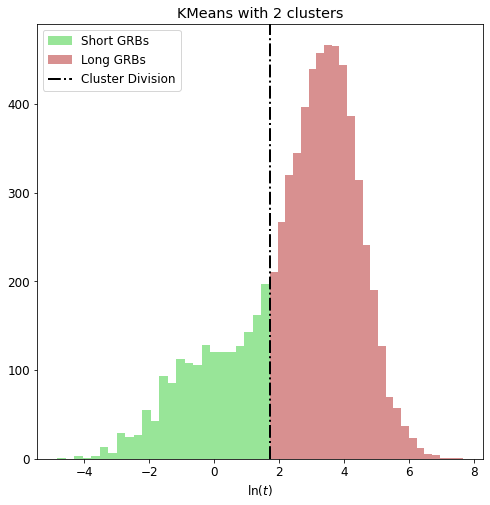

In [12]:
#Plot the data -> Color-coded by cluster id

colors = ['limegreen', 'firebrick']
lab = ['Short GRBs', 'Long GRBs']
for i in range(2):
    plt.hist(x=t90_log[labels == i], bins=25, color=colors[i],alpha=0.5, label=lab[i])


#Picking the minimum value of the second cluster as dividing line
line = min(t90_log[labels == 1])


#Showing division
plt.title('KMeans with 2 clusters')
plt.axvline(x=line, ls='-.', lw=2, c='k', label='Cluster Division')
plt.xlabel(r'$\ln(t)$')
plt.legend()
plt.show()

## Gaussian Mixture Model

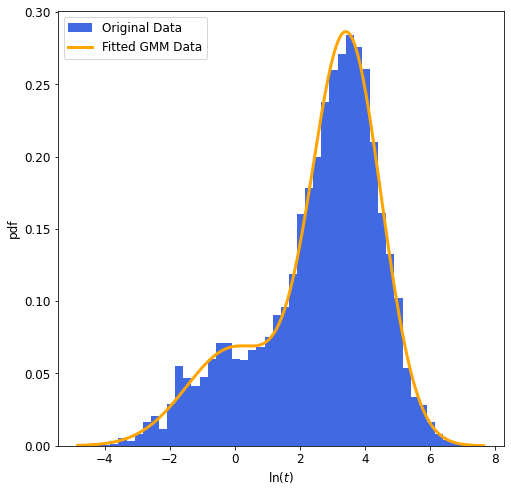

In [13]:
gmm = gauss(n_components=2)
gmm.fit(t90_log[:, None])

pdf = np.exp(gmm.score_samples(tgrid[:, None]))  #Exponentiating the log-likelihood(score_samples)

#Plotting fitted pdf
plt.hist(t90_log, bins=50, density=True, color='royalblue', label='Original Data', zorder=1)
plt.plot(tgrid, pdf, c='orange', label='Fitted GMM Data', linewidth=3, zorder=2)

plt.xlabel(r'$\ln(t)$')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [14]:
#Centers of the gaussians
gmm_centers = gmm.means_

#Labels of the gaussians
gmm_labels = gmm.predict(t90_log[:, None])

In [28]:
#Creating pdf for the whole model
superpos = gmm.predict_proba(tgrid[:, None])

#Isolating individual-modes pdfs
single_gaussians = superpos * pdf[:, None]

In [29]:
#Same as before, reordering centers in increasing order
if gmm_centers[0] > gmm_centers[1]:
    gmm_centers = gmm_centers[::-1]
    gmm_labels = gmm_labels[::-1]
    single_gaussians = single_gaussians[:, ::-1]

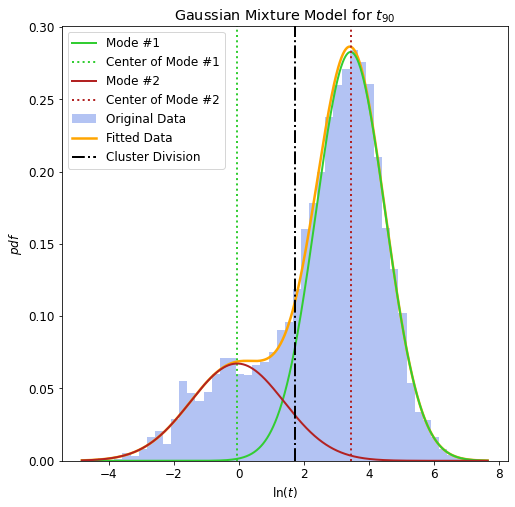

In [30]:
#Plotting individual modes
for i in range(2):
    current_plot = 'Mode #' + str(i + 1)
    plt.plot(tgrid, single_gaussians[:, i], label=current_plot, zorder=2, lw=2, c=colors[i])
    plt.axvline(x=gmm_centers[i], ls=':', c=colors[i], lw=2, label='Center of '+current_plot)

#Plotting whole fit
plt.hist(t90_log, bins=50, density=True, color='royalblue', label='Original Data', zorder=1, alpha=0.4)
plt.plot(tgrid, pdf, label='Fitted Data', zorder=1, lw=2.5, c='orange')

#Cluster division
gmm_line = min(t90_log[labels == 1])
plt.axvline(x=gmm_line, ls='-.', lw=2, c='k', label='Cluster Division')

plt.xlabel(r'$\ln(t)$')
plt.ylabel(r'$pdf$')
plt.title(r'Gaussian Mixture Model for $t_{90}$')
plt.legend(loc='upper left')
plt.show()

In [32]:
#Sanity check on cluster boundaries obtained with the two methods
print('Cluster division estimated with K-Means: ', line)
print('Cluster division estimated with Gaussian Mixture: ', gmm_line)

Cluster division estimated with K-Means:  1.7170359230321184
Cluster division estimated with Gaussian Mixture:  1.7170359230321184
